In [1]:
!pip install -r /kaggle/input/necessary-files/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 75.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 89.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 91.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 86.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 70.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

**Encoder Decoder**


In [2]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision.datasets.folder import default_loader

In [3]:

class AttDataset(Dataset):
    def __init__(self, csv_file, attribute_columns, image_dir="", transform=None, multiply=1, attribute_encoders=None, loader=default_loader):
        if isinstance(csv_file, pd.DataFrame):
            self.df = csv_file
        else:
            self.df = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform
        self.multiply = multiply
        self.attribute_columns = attribute_columns
        self.attribute_encoders = attribute_encoders or self.create_attribute_encoders()
        self.attribute_decoders = self.create_attribute_decoders(
            self.attribute_encoders)
        self.loader = loader

    def create_attribute_encoders(self):
        attribute_encoders = {}
        for col in self.attribute_columns:
            attribute_encoders[col] = {
                value: idx for idx, value in enumerate(sorted(self.df[col].unique()))}
        return attribute_encoders

    def create_attribute_decoders(self, attribute_encoders):
        # Create reverse mapping for each dictionary
        attribute_decoders = {}
        for col, encoding in attribute_encoders.items():
            attribute_decoders[col] = {v: k for k, v in encoding.items()}
        return attribute_decoders

    def __len__(self):
        return len(self.df) * self.multiply

    def __getitem__(self, idx):
        idx = idx % len(self.df)
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image_path = os.path.join(self.image_dir, self.df.loc[idx, 'path'])
        image = self.loader(image_path)
        attributes = [self.attribute_encoders[col][self.df.loc[idx, col]]
                      for col in self.attribute_columns]
        sample = {'image': image, 'attributes': torch.tensor(
            attributes, dtype=torch.long), 'img_path': image_path}
        if self.transform:
            sample['image'] = self.transform(sample['image'])
        return sample

**Attribute Predictor**

In [4]:
import torch.nn as nn


class AttributePredictor(nn.Module):
    def __init__(self, attribute_sizes, image_encoder_output_dim, image_encoder):
        super().__init__()
        self.image_encoder = image_encoder
        self.attribute_sizes = attribute_sizes
        self.attribute_predictors = nn.ModuleList(
            [nn.Linear(image_encoder_output_dim, size) for size in attribute_sizes])
        # Apply Kaiming initialization to the attribute predictors
        for predictor in self.attribute_predictors:
            nn.init.kaiming_normal_(predictor.weight, nonlinearity='relu')
            nn.init.zeros_(predictor.bias)

    def predict_from_features(self, x):
        # Predict each attribute
        outputs = [predictor(x) for predictor in self.attribute_predictors]
        return outputs

    def forward(self, x):
        x = self.image_encoder(x)
        x = x.view(x.size(0), -1)  # Flatten the image features
        outputs = self.predict_from_features(x)
        return outputs

**Train and Eval**


In [5]:
import argparse
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import json
from tqdm.auto import tqdm
from io import BytesIO
import numpy as np
import random

In [6]:
att_names = [
    "cell_size",
    "cell_shape",
    "nucleus_shape",
    "nuclear_cytoplasmic_ratio",
    "chromatin_density",
    "cytoplasm_vacuole",
    "cytoplasm_texture",
    "cytoplasm_colour",
    "granule_type",
    "granule_colour",
    "granularity",
]

In [7]:


def save_args(savedir, args, name="args.json"):
    # save args as "args.json" in the savedir
    path = os.path.join(savedir, name)
    with open(path, "w") as f:
        json.dump(vars(args), f, sort_keys=True, indent=4)
    print("args saved as %s" % path)


def save_json(dict, path):
    with open(path, "w") as f:
        json.dump(dict, f, sort_keys=True, indent=4)
        print("log saved at %s" % path)


def save_checkpoint(path, model, key="model"):
    # save model state dict
    checkpoint = {}
    checkpoint[key] = model.state_dict()
    torch.save(checkpoint, path)
    print("checkpoint saved at", path)

In [8]:
def resume_model(model, resume, state_dict_key="model"):
    """
    model:pytorch model
    resume: path to the resume file
    state_dict_key: dict key
    """
    print("resuming trained weights from %s" % resume)

    checkpoint = torch.load(resume, map_location="cpu")
    if state_dict_key is not None:
        pretrained_dict = checkpoint[state_dict_key]
    else:
        pretrained_dict = checkpoint

    try:
        model.load_state_dict(pretrained_dict)
    except RuntimeError as e:
        print(e)
        print(
            "can't load the all weights due to error above, trying to load part of them!"
        )
        model_dict = model.state_dict()
        # 1. filter out unnecessary keys
        pretrained_dict_use = {}
        pretrained_dict_ignored = {}
        for k, v in pretrained_dict.items():
            if k in model_dict:
                pretrained_dict_use[k] = v
            else:
                pretrained_dict_ignored[k] = v
        pretrained_dict = pretrained_dict_use
        # 2. overwrite entries in the existing state dict
        model_dict.update(pretrained_dict)
        # 3. load the new state dict
        model.load_state_dict(model_dict)
        print("resumed only", pretrained_dict.keys())
        print("ignored:", pretrained_dict_ignored.keys())

    return model

In [9]:
def make_deterministic(seed):
    # https://github.com/pytorch/pytorch/issues/7068#issuecomment-487907668
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [10]:
def calculate_metrics(true_labels, predicted_probs):
    predicted_probs = np.array(predicted_probs)
    true_labels = np.array(true_labels)
    predicted_labels = np.argmax(predicted_probs, axis=1)
    metrics = {
        "acc": accuracy_score(true_labels, predicted_labels),
        "f1_macro": f1_score(true_labels, predicted_labels, average="macro"),
        "pre_macro": precision_score(true_labels, predicted_labels, average="macro"),
        "rec_macro": recall_score(true_labels, predicted_labels, average="macro"),
    }
    return metrics

In [11]:
def get_transforms(split, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    if split == "train":
        return transforms.Compose(
            [
                transforms.Resize(256),
                transforms.RandomCrop((224, 224)),
                transforms.ToTensor(),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.Normalize(mean=mean, std=std),
            ]
        )
    else:
        return transforms.Compose(
            [
                transforms.Resize(256),
                transforms.CenterCrop((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=mean, std=std),
            ]
        )


In [12]:
def get_image_encoder(name, pretrained=True):
    weights = "DEFAULT" if pretrained else None
    model = getattr(torchvision.models, name)(weights=weights)
    if name.startswith("vgg"):
        model.classifier[6] = nn.Identity()
    elif name.startswith("resnet"):
        model.fc = nn.Identity()
    elif name.startswith("vit"):
        model.heads = nn.Identity()
    elif name.startswith("convnext"):
        model.classifier[-1] = nn.Identity()
    else:
        raise ValueError(f"Unsupported image encoder: {name}")
    # Infer the output size of the image encoder
    with torch.inference_mode():
        out = model(torch.randn(5, 3, 224, 224))
    assert out.dim() == 2
    assert out.size(0) == 5
    image_encoder_output_dim = out.size(1)
    return model, image_encoder_output_dim

In [13]:
def save_predictions_to_csv(predictions, log_dir, filename, dataloader_val):
    decoded_predictions = []
    for j, preds in enumerate(predictions):
        attribute = dataloader_val.dataset.attribute_columns[j]
        encoder = dataloader_val.dataset.attribute_encoders[attribute]
        # Create a reverse mapping
        decoder = {v: k for k, v in encoder.items()}
        decoded_preds = [decoder[np.argmax(p)] for p in preds]
        decoded_predictions.append(decoded_preds)
    data = {"image_path": dataloader_val.dataset.df["path"]}
    data.update(
        {
            attribute: preds
            for attribute, preds in zip(
                dataloader_val.dataset.attribute_columns, decoded_predictions
            )
        }
    )
    df = pd.DataFrame(data)
    df.to_csv(os.path.join(log_dir, filename), index=False)


In [14]:
def evaluate(model, dataloader):
    model.eval()
    num_attributes = len(dataloader.dataset.attribute_columns)
    all_predictions = [[] for _ in range(num_attributes)]
    all_probabilities = [[] for _ in range(num_attributes)]
    all_true_labels = [[] for _ in range(num_attributes)]
    all_image_paths = []
    with torch.inference_mode():
        for i, data in enumerate(dataloader):
            images, attributes = data["image"], data["attributes"]
            images, attributes = images.cuda(), attributes.cuda()
            model_outputs = model(images)
            for j, model_output in enumerate(model_outputs):
                model_output = torch.softmax(model_output, dim=1)
                all_probabilities[j].extend(model_output.cpu().tolist())
                all_predictions[j].extend(
                    torch.argmax(model_output, dim=1).cpu().tolist()
                )
                all_true_labels[j].extend(attributes[:, j].cpu().tolist())
            all_image_paths.extend(data["img_path"])
    # Call calculate_metrics once with a fake data to get the list of available metrics
    _, initial_metrics = next(
        iter(dataloader.dataset.attribute_columns)
    ), calculate_metrics([0, 1, 1], [[0.98, 0.02], [0.02, 0.98], [0.60, 0.40]])
    overall_metrics = {metric: 0.0 for metric in initial_metrics.keys()}
    per_attribute_metrics = {
        column: {} for column in dataloader.dataset.attribute_columns
    }
    for j, attribute in enumerate(dataloader.dataset.attribute_columns):
        metrics = calculate_metrics(all_true_labels[j], all_probabilities[j])
        for metric in overall_metrics.keys():
            overall_metrics[metric] += metrics[metric]
        per_attribute_metrics[attribute] = metrics
    for metric in overall_metrics.keys():
        overall_metrics[metric] /= num_attributes
    return {
        "overall_metrics": overall_metrics,
        "per_attribute_metrics": per_attribute_metrics,
        "all_image_paths": all_image_paths,
        "all_probabilities": all_probabilities,
        "all_predictions": all_predictions,
    }


In [18]:
def get_args():
    parser = argparse.ArgumentParser(description="Train an attribute prediction model.")
    parser.add_argument("--train", default="/kaggle/input/necessary-files/pbc_attr_v1_train.csv", help="Path to the training CSV file")
    parser.add_argument("--val", default="/kaggle/input/necessary-files/pbc_attr_v1_val.csv", help="Path to the validation CSV file")
    parser.add_argument("--test", default="/kaggle/input/necessary-files/pbc_attr_v1_test.csv", help="Path to the test CSV file")
    parser.add_argument("--image_dir", default="/kaggle/input/pcb-dataset/", help="Root directory containing image files")
    parser.add_argument("--epochs", type=int, default=30, help="Number of training epochs")
    parser.add_argument("--epoch_multiply", type=int, default=1, help="Number of times to repeat the dataset in each epoch")
    parser.add_argument("--lr", type=float, default=0.0001, help="Learning rate")
    parser.add_argument("--decay", type=float, default=0.01, help="weight decay")
    parser.add_argument("--batch_size", type=int, default=128, help="Batch size")
    parser.add_argument("--eval_metric", default="f1_macro", help="Evaluation metric for model selection")
    parser.add_argument("--backbone", default="resnet50", help="Choice of image encoder", choices=["vgg16", "resnet50", "convnext_tiny", "vit_b_16"])
    parser.add_argument("--use_eval_mode", action="store_true", help="Use model.eval() even for training. ResNet often improves the performance with this.")
    parser.add_argument("--resume", default=None, help="Path to a pretrained model")
    parser.add_argument("--logdir", default="./log", help="Directory to save experiment logs")
    parser.add_argument("--seed", default=1, type=int, help="Random seed.")
    parser.add_argument("--workers", type=int, default=8, help="Workers for torch.utils.data.DataLoader")

    args, unknown = parser.parse_known_args()  # This ignores extra args from Jupyter
    return args




In [16]:
def main(args):
    print(args)

    # set seed
    make_deterministic(args.seed)

    # setup the directory to save the experiment log and trained models
    log = {}
    log_dir = args.logdir
    if not os.path.exists(log_dir):
        os.mkdir(log_dir)
    log_path = os.path.join(log_dir, "log.json")
    save_json(log, log_path)
    save_args(log_dir, args)

    # setup image encoder
    image_encoder, image_encoder_output_dim = get_image_encoder(args.backbone)

    # setup dataset and dataloader
    dataset_train = AttDataset(
        args.train,
        att_names,
        image_dir=args.image_dir,
        transform=get_transforms("train"),
        multiply=args.epoch_multiply,
    )
    dataset_val = AttDataset(
        args.val,
        att_names,
        image_dir=args.image_dir,
        transform=get_transforms("test"),
        attribute_encoders=dataset_train.attribute_encoders,
    )
    dataset_test = AttDataset(
        args.test,
        att_names,
        image_dir=args.image_dir,
        transform=get_transforms("test"),
        attribute_encoders=dataset_train.attribute_encoders,
    )
    attribute_sizes = [
        len(encoder) for encoder in dataset_train.attribute_encoders.values()
    ]
    # testing attributes should be the same set or at least subset of training
    # if testing set contains attribute value  that has not appeared in  training set, things will be broken.
    for column in dataset_val.attribute_columns + dataset_test.attribute_columns:
        for value in sorted(dataset_val.df[column].unique()):
            assert (
                value in dataset_train.attribute_encoders[column]
            ), f"Attribute value '{value}' in column '{column}' not found in training dataset"
    dataloader_train = DataLoader(
        dataset_train,
        batch_size=args.batch_size,
        shuffle=True,
        num_workers=args.workers,
        persistent_workers=(args.workers > 0),
        pin_memory=True,
        drop_last=True,
    )
    dataloader_val = DataLoader(
        dataset_val,
        batch_size=args.batch_size,
        shuffle=False,
        num_workers=args.workers,
        persistent_workers=(args.workers > 0),
        pin_memory=True,
        drop_last=False,
    )
    dataloader_test = DataLoader(
        dataset_test,
        batch_size=args.batch_size,
        shuffle=False,
        num_workers=args.workers,
        persistent_workers=(args.workers > 0),
        pin_memory=True,
        drop_last=False,
    )

    model = AttributePredictor(attribute_sizes, image_encoder_output_dim, image_encoder)
    if args.resume is not None:
        image_encoder = resume_model(
            model, args.resume, state_dict_key="model"
        )

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(
        model.parameters(), lr=args.lr, weight_decay=args.decay
    )

    model.cuda()
    best_val_metric = 0
    model_data_in_memory = None
    epoch = -1

    training_logs = []
    best_epoch = 0
    for epoch in range(args.epochs):
        if not args.use_eval_mode:
            model.train()
        running_loss = 0.0
        num_processed_samples = 0
        with tqdm(
            dataloader_train, desc=f"Epoch {epoch + 1}/{args.epochs}", unit="batch"
        ) as t:
            for i, data in enumerate(t):
                images, attribute_targets = data["image"], data["attributes"]
                images, attribute_targets = images.cuda(), attribute_targets.cuda()
                optimizer.zero_grad()
                attribute_outputs = model(images)
                loss = 0
                for idx, (output, target) in enumerate(
                    zip(attribute_outputs, attribute_targets.t())
                ):
                    loss += criterion(output, target)
                # average loss over all attributes. just rescaling.
                loss = loss / len(attribute_outputs)
                loss.backward()
                optimizer.step()
                batch_size = images.size(0)
                running_loss += loss.item() * batch_size
                num_processed_samples += batch_size
                t.set_postfix(train_loss=(running_loss / num_processed_samples))
        training_loss = running_loss / num_processed_samples
        evaluation_results = evaluate(model, dataloader_val)
        overall_metrics, per_attribute_metrics, _, _, _ = evaluation_results.values()
        print(
            f"Epoch {epoch + 1}, Overall Metrics on Val: "
            + ", ".join([f"{k}: {(100*v):.2f}" for k, v in overall_metrics.items()])
        )
        val_metric = overall_metrics[args.eval_metric]
        # Save the best model based on f1_macro
        if val_metric > best_val_metric:
            best_epoch = epoch
            best_val_metric = val_metric
            # https://discuss.pytorch.org/t/how-to-make-a-copy-of-a-gpu-model-on-the-cpu/90955/4
            # Save the model to memory from GPU
            model_data_in_memory = BytesIO()
            torch.save(model.state_dict(), model_data_in_memory, pickle_protocol=-1)
            model_data_in_memory.seek(0)

        # Log training progress
        training_log = {
            "epoch": epoch + 1,
            "training_loss": training_loss,
            "evaluation": evaluation_results,
        }
        training_logs.append(training_log)
        log["trainining"] = training_logs
        save_json(log, log_path)

    print("Best Epoch", best_epoch + 1)
    # Evaluate the bestval model on the test set
    # Load the model from memory to CPU and then send to GPU
    if model_data_in_memory is not None:
        model_in_cpu = torch.load(model_data_in_memory, map_location="cpu")
        model_data_in_memory.close()
        model.load_state_dict(model_in_cpu)
        model.cuda()
    evaluation_results = evaluate(model, dataloader_test)
    overall_metrics_best = evaluation_results["overall_metrics"]
    best_decoded_predictions = evaluation_results["all_probabilities"]
    print(
        f"Epoch {epoch + 1}, BestValModel Overall Metrics on Test: "
        + ", ".join([f"{k}: {(100*v):.2f}" for k, v in overall_metrics_best.items()])
    )
    save_predictions_to_csv(
        best_decoded_predictions,
        log_dir,
        "bestval_epoch_predictions.csv",
        dataloader_test,
    )
    log["bestval"] = evaluation_results
    save_json(log, log_path)
    # Save the best model
    best_model_path = os.path.join(log_dir, "best_model.pth")
    save_checkpoint(best_model_path, model, key="model")


In [19]:
if __name__ == "__main__":
    args = get_args()
    main(args)

Namespace(train='/kaggle/input/necessary-files/pbc_attr_v1_train.csv', val='/kaggle/input/necessary-files/pbc_attr_v1_val.csv', test='/kaggle/input/necessary-files/pbc_attr_v1_test.csv', image_dir='/kaggle/input/pcb-dataset/', epochs=30, epoch_multiply=1, lr=0.0001, decay=0.01, batch_size=128, eval_metric='f1_macro', backbone='resnet50', use_eval_mode=False, resume=None, logdir='./log', seed=1, workers=8)
log saved at ./log/log.json
args saved as ./log/args.json


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 1/30:   0%|          | 0/48 [00:00<?, ?batch/s]

Epoch 1, Overall Metrics on Val: acc: 90.76, f1_macro: 84.33, pre_macro: 87.54, rec_macro: 83.89
log saved at ./log/log.json


Epoch 2/30:   0%|          | 0/48 [00:00<?, ?batch/s]

Epoch 2, Overall Metrics on Val: acc: 92.41, f1_macro: 88.53, pre_macro: 89.50, rec_macro: 88.66
log saved at ./log/log.json


Epoch 3/30:   0%|          | 0/48 [00:00<?, ?batch/s]

Epoch 3, Overall Metrics on Val: acc: 93.07, f1_macro: 89.66, pre_macro: 90.32, rec_macro: 89.66
log saved at ./log/log.json


Epoch 4/30:   0%|          | 0/48 [00:00<?, ?batch/s]

Epoch 4, Overall Metrics on Val: acc: 93.05, f1_macro: 89.73, pre_macro: 90.68, rec_macro: 89.27
log saved at ./log/log.json


Epoch 5/30:   0%|          | 0/48 [00:00<?, ?batch/s]

Epoch 5, Overall Metrics on Val: acc: 93.42, f1_macro: 90.61, pre_macro: 90.37, rec_macro: 91.00
log saved at ./log/log.json


Epoch 6/30:   0%|          | 0/48 [00:00<?, ?batch/s]

Epoch 6, Overall Metrics on Val: acc: 93.55, f1_macro: 90.17, pre_macro: 91.03, rec_macro: 89.63
log saved at ./log/log.json


Epoch 7/30:   0%|          | 0/48 [00:00<?, ?batch/s]

Epoch 7, Overall Metrics on Val: acc: 93.39, f1_macro: 90.31, pre_macro: 91.34, rec_macro: 89.80
log saved at ./log/log.json


Epoch 8/30:   0%|          | 0/48 [00:00<?, ?batch/s]

Epoch 8, Overall Metrics on Val: acc: 93.49, f1_macro: 90.04, pre_macro: 90.66, rec_macro: 89.96
log saved at ./log/log.json


Epoch 9/30:   0%|          | 0/48 [00:00<?, ?batch/s]

Epoch 9, Overall Metrics on Val: acc: 93.59, f1_macro: 90.16, pre_macro: 90.93, rec_macro: 89.83
log saved at ./log/log.json


Epoch 10/30:   0%|          | 0/48 [00:00<?, ?batch/s]

Epoch 10, Overall Metrics on Val: acc: 93.64, f1_macro: 90.43, pre_macro: 91.04, rec_macro: 90.16
log saved at ./log/log.json


Epoch 11/30:   0%|          | 0/48 [00:00<?, ?batch/s]

Epoch 11, Overall Metrics on Val: acc: 93.74, f1_macro: 90.39, pre_macro: 91.56, rec_macro: 89.63
log saved at ./log/log.json


Epoch 12/30:   0%|          | 0/48 [00:00<?, ?batch/s]

Epoch 12, Overall Metrics on Val: acc: 93.17, f1_macro: 89.20, pre_macro: 90.40, rec_macro: 89.24
log saved at ./log/log.json


Epoch 13/30:   0%|          | 0/48 [00:00<?, ?batch/s]

Epoch 13, Overall Metrics on Val: acc: 93.54, f1_macro: 90.29, pre_macro: 91.29, rec_macro: 89.70
log saved at ./log/log.json


Epoch 14/30:   0%|          | 0/48 [00:00<?, ?batch/s]

Epoch 14, Overall Metrics on Val: acc: 93.63, f1_macro: 90.11, pre_macro: 90.38, rec_macro: 90.43
log saved at ./log/log.json


Epoch 15/30:   0%|          | 0/48 [00:00<?, ?batch/s]

Epoch 15, Overall Metrics on Val: acc: 93.80, f1_macro: 90.77, pre_macro: 90.88, rec_macro: 90.88
log saved at ./log/log.json


Epoch 16/30:   0%|          | 0/48 [00:00<?, ?batch/s]

Epoch 16, Overall Metrics on Val: acc: 93.93, f1_macro: 90.89, pre_macro: 90.61, rec_macro: 91.45
log saved at ./log/log.json


Epoch 17/30:   0%|          | 0/48 [00:00<?, ?batch/s]

Epoch 17, Overall Metrics on Val: acc: 93.35, f1_macro: 89.99, pre_macro: 91.00, rec_macro: 89.27
log saved at ./log/log.json


Epoch 18/30:   0%|          | 0/48 [00:00<?, ?batch/s]

Epoch 18, Overall Metrics on Val: acc: 93.52, f1_macro: 90.58, pre_macro: 90.63, rec_macro: 90.77
log saved at ./log/log.json


Epoch 19/30:   0%|          | 0/48 [00:00<?, ?batch/s]

Epoch 19, Overall Metrics on Val: acc: 93.82, f1_macro: 90.30, pre_macro: 91.05, rec_macro: 90.00
log saved at ./log/log.json


Epoch 20/30:   0%|          | 0/48 [00:00<?, ?batch/s]

Epoch 20, Overall Metrics on Val: acc: 93.72, f1_macro: 90.50, pre_macro: 91.29, rec_macro: 89.98
Epoch 22, Overall Metrics on Val: acc: 93.50, f1_macro: 90.06, pre_macro: 90.65, rec_macro: 89.63
log saved at ./log/log.json


Epoch 23/30:   0%|          | 0/48 [00:00<?, ?batch/s]

Epoch 23, Overall Metrics on Val: acc: 93.54, f1_macro: 90.16, pre_macro: 90.79, rec_macro: 89.77
log saved at ./log/log.json


Epoch 24/30:   0%|          | 0/48 [00:00<?, ?batch/s]

Epoch 24, Overall Metrics on Val: acc: 93.50, f1_macro: 90.25, pre_macro: 90.88, rec_macro: 89.91
log saved at ./log/log.json


Epoch 25/30:   0%|          | 0/48 [00:00<?, ?batch/s]

Epoch 25, Overall Metrics on Val: acc: 93.66, f1_macro: 90.49, pre_macro: 90.66, rec_macro: 90.47
log saved at ./log/log.json


Epoch 26/30:   0%|          | 0/48 [00:00<?, ?batch/s]

Epoch 26, Overall Metrics on Val: acc: 93.65, f1_macro: 89.97, pre_macro: 90.95, rec_macro: 89.50
log saved at ./log/log.json


Epoch 27/30:   0%|          | 0/48 [00:00<?, ?batch/s]

Epoch 27, Overall Metrics on Val: acc: 93.71, f1_macro: 90.41, pre_macro: 90.89, rec_macro: 90.12
log saved at ./log/log.json


Epoch 28/30:   0%|          | 0/48 [00:00<?, ?batch/s]

Epoch 28, Overall Metrics on Val: acc: 93.86, f1_macro: 90.71, pre_macro: 91.41, rec_macro: 90.25
log saved at ./log/log.json


Epoch 29/30:   0%|          | 0/48 [00:00<?, ?batch/s]

Epoch 29, Overall Metrics on Val: acc: 93.81, f1_macro: 90.64, pre_macro: 90.68, rec_macro: 90.72
log saved at ./log/log.json


Epoch 30/30:   0%|          | 0/48 [00:00<?, ?batch/s]

Epoch 30, Overall Metrics on Val: acc: 93.62, f1_macro: 90.29, pre_macro: 91.29, rec_macro: 89.72
log saved at ./log/log.json
Best Epoch 16


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 30, BestValModel Overall Metrics on Test: acc: 93.82, f1_macro: 90.89, pre_macro: 90.72, rec_macro: 91.28
log saved at ./log/log.json
checkpoint saved at ./log/best_model.pth


In [29]:
import torchvision.models as models
from torch import nn
# Step 1: Load ResNet model (or another backbone)
resnet = models.resnet18(pretrained=True)  # Using ResNet18 as an example backbone
resnet.fc = nn.Identity()  # Remove the final classification layer

# Step 2: Define the AttributePredictor model with ResNet as the backbone
attribute_sizes = [5, 3]  # Example attribute sizes (adjust as needed)
image_encoder_output_dim = 512  # Example output dimension after ResNet
model = AttributePredictor(attribute_sizes=attribute_sizes, 
                           image_encoder_output_dim=image_encoder_output_dim, 
                           image_encoder=resnet)

model_dict = model.state_dict()
pretrained_dict = torch.load('/kaggle/working/log/best_model.pth')

# Filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}

# Overwrite current model weights with pretrained weights
model_dict.update(pretrained_dict)

# Load the new state dict
model.load_state_dict(model_dict)


model.eval()

AttributePredictor(
  (image_encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

Predicted attribute indices: [1, 2]
Decoded attributes: ['small', 'Unknown (2)']


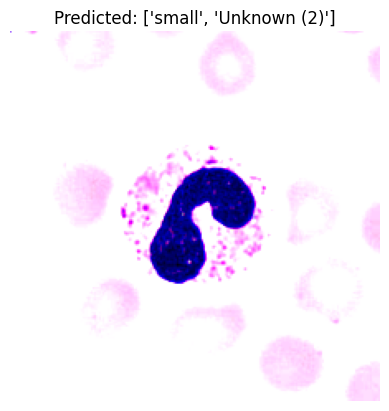

In [43]:
import torch
import matplotlib.pyplot as plt
from PIL import Image

def predict_image(image_path, model, transform, attribute_columns, attribute_decoders=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load and transform the image
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension (1, C, H, W)
    
    # Move the image to the chosen device (GPU or CPU)
    image = image.to(device)

    # Set the model to evaluation mode and move the model to the device
    model.eval()
    model.to(device)

    # Disable gradients since we are in inference mode
    with torch.no_grad():
        # Forward pass through the model
        outputs = model(image)
    
    # Post-process predictions
    predicted_attributes = [output.argmax(dim=1).item() for output in outputs]  # Get predicted indices
    
    # Debugging step: print predicted attributes and their corresponding columns
    print(f"Predicted attribute indices: {predicted_attributes}")
    
    # Check if the predicted attribute indices are valid for each decoder
    for idx, (col, attr_idx) in enumerate(zip(attribute_columns, predicted_attributes)):
        # Check if the predicted index is within the valid range for this attribute
        num_classes = len(attribute_decoders.get(col, []))
        if attr_idx >= num_classes:
            print(f"Warning: Predicted index {attr_idx} is out of range for column {col} (max: {num_classes - 1})")
    
    # Decode the predicted attributes to their original values
    decoded_attributes = []
    for col, attr in zip(attribute_columns, predicted_attributes):
        if col in attribute_decoders and attr in attribute_decoders[col]:
            decoded_attributes.append(attribute_decoders[col][attr])
        else:
            decoded_attributes.append(f"Unknown ({attr})")  # Default value in case of out-of-range index

    print(f"Decoded attributes: {decoded_attributes}")
    
    # Show the image with the predicted attributes as the title
    plt.imshow(image.permute(0, 2, 3, 1).squeeze(0).cpu())  # Convert from (1, C, H, W) to (H, W, C)
    plt.title(f"Predicted: {decoded_attributes}")  # Change this line as needed to show more information
    plt.axis("off")
    plt.show()

# Example usage
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to fit the model's expected input size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# Use your dataset to get the attribute_decoders
dataset_train = AttDataset(
    csv_file='/kaggle/input/necessary-files/pbc_attr_v1_train.csv',
    attribute_columns=att_names,  # Replace with your attributes
    image_dir='/kaggle/input/pcb-dataset',
    transform=get_transforms('test')
)

# Get attribute_decoders from the dataset
attribute_decoders = dataset_train.attribute_decoders

# Path to the image you want to predict
image_path = "/kaggle/input/pcb-dataset/PBC_dataset_normal_DIB/neutrophil/BNE_101007.jpg"

# Call the prediction function
predict_image(image_path, model, transform, att_names, attribute_decoders)
